In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
from sklearn.datasets import make_blobs

In [3]:
dataset = make_blobs(n_samples=10000, centers=3, random_state=42)
total_samples = dataset[0].shape[0]
r_train, r_cal, r_test = 0.6, 0.2, 0.2
assert r_train + r_cal + r_test == 1
Z_train = dataset[0][: int(total_samples * r_train)]
Z_cal = dataset[0][
    int(total_samples * r_train) : int(total_samples * r_train)
    + int(total_samples * r_cal)
]
Z_test = dataset[0][int(total_samples * r_train) + int(total_samples * r_cal) :]
Z_eval = dataset[0][int(total_samples * r_train):]

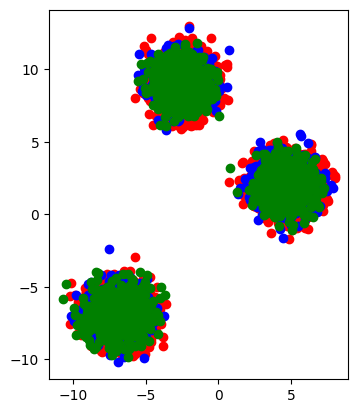

In [4]:
plt.scatter(Z_train[:, 0], Z_train[:, 1], color="red", marker="o", label="train")
plt.scatter(Z_cal[:, 0], Z_cal[:, 1], color="blue", marker="o", label="cal")
plt.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker="o", label="test")
plt.gca().set_aspect("equal")

In [5]:
from conformal_region_designer.density_estimation import KDE
from conformal_region_designer.clustering import MeanShiftClustering
from conformal_region_designer.shapes import HyperRectangle
from conformal_region_designer.conformity_optimizer import ConformalRegion

In [6]:
DELTA = 0.95
de = KDE()
cl = MeanShiftClustering()
pcr = ConformalRegion(de, cl, HyperRectangle, DELTA)

In [7]:
pcr.fit(Z_train)

In [8]:
pcr.normalizing_constant = np.ones_like(pcr.normalizing_constant)

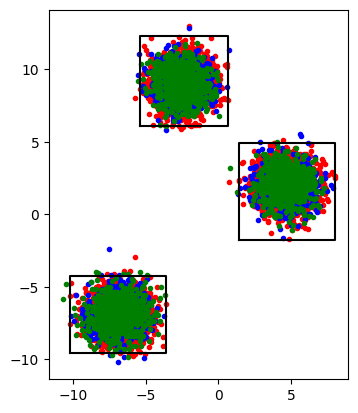

In [9]:
fig, ax = plt.subplots()
ax.scatter(Z_train[:, 0], Z_train[:, 1], color="red", marker=".", label="train")
ax.scatter(Z_cal[:, 0], Z_cal[:, 1], color="blue", marker=".", label="cal")
ax.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="test")
ax.set_aspect("equal")
for shape_template in pcr.shapes:
    shape_template.plot(ax)

In [10]:
pcr.conformalize(Z_cal)

In [11]:
scores = pcr.calculate_scores(Z_test)
coverage = np.sum(scores < 0) / len(scores)
print("Test Coverage: ", coverage)
scores = pcr.calculate_scores(Z_cal)
coverage = np.sum(scores < 0) / len(scores)
print("Calibration Coverage: ", coverage)


Test Coverage:  0.9465
Calibration Coverage:  0.9505


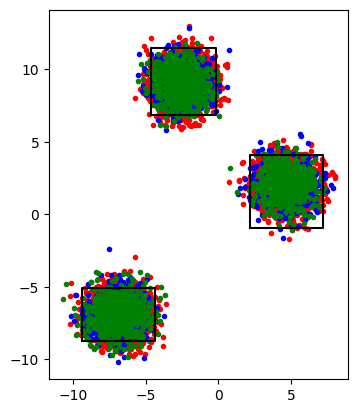

In [12]:
fig, ax = plt.subplots()
ax.scatter(Z_train[:, 0], Z_train[:, 1], color="red", marker=".", label="train")
ax.scatter(Z_cal[:, 0], Z_cal[:, 1], color="blue", marker=".", label="cal")
ax.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="test")
ax.set_aspect("equal")
for shape_template in pcr.shapes:
    shape_template.plot(ax)

In [13]:
from conformal_region_designer.utils import conformalized_quantile
target_quantile = conformalized_quantile(len(Z_train), DELTA)
print(target_quantile)

0.9501666666666667


In [14]:
# We need to do one hundred different splits of the data into calibration and test sets, to get a good estimate of the coverage.
# We will use the same training set for all splits.
from sklearn.model_selection import ShuffleSplit
from tqdm.autonotebook import tqdm
rs = ShuffleSplit(n_splits=1000, test_size=0.5, random_state=42)
rs.get_n_splits(Z_eval)
coverages = []
with tqdm(total=rs.get_n_splits(Z_eval)) as pbar:
    for cal_index, test_index in rs.split(Z_eval):
        Z_cal = Z_eval[cal_index]
        Z_test = Z_eval[test_index]
        pcr.conformalize(Z_cal)
        scores = pcr.calculate_scores(Z_test)
        coverage = np.sum(scores < 0) / len(scores)
        coverages.append(coverage)
        pbar.update(1)
        pbar.set_description(f"Coverage: {coverage}")

/tmp/ipykernel_773251/3889045432.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/1000 [00:00<?, ?it/s]

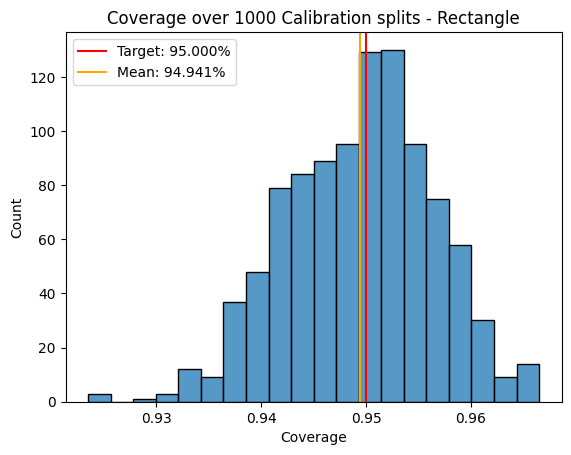

In [22]:
sns.histplot(coverages, bins=20)
plt.axvline(x=DELTA, color="red", label=f"Target: {DELTA:.3%}")
plt.axvline(x=np.mean(coverages), color="orange", label=f"Mean: {np.mean(coverages):.3%}")
plt.title("Coverage over 1000 Calibration splits - Rectangle")
plt.xlabel("Coverage")
plt.ylabel("Count")
plt.legend()